In [360]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import plotly
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=4)
sns.set_style("whitegrid")
sns.set_context("poster",font_scale=3, rc={'grid.color': 'white', "grid.linewidth": 3,"lines.linewidth": 2.5})

In [361]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [362]:
url_covid_data = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv'
df_latest_covid_data = pd.read_csv(url_covid_data)
df_latest_covid_data['countyFIPS']  = df_latest_covid_data['countyFIPS'].astype(str).str.zfill(5)
df_latest_covid_data.sample(2)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
80,02122,Kenai Peninsula Borough,AK,2,0,0,0,0,0,0,...,0,0,3,3,4,5,5,5,7,7
929,20047,Edwards County,KS,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [363]:
# Downloads the 2018 County Population
county_pop_fpath = './Data/nhgis0005_csv/nhgis0005_ds239_20185_2018_county.csv'
df_county_pop = pd.read_csv(county_pop_fpath,encoding='latin-1')
df_county_pop['countyFIPS'] = df_county_pop['STATEA'].astype(str) +  df_county_pop['COUNTYA'].astype(str).str.zfill(3)
df_county_pop['countyFIPS'] = df_county_pop['countyFIPS'].astype(str).str.zfill(5)
df_county_pop = df_county_pop[['STATE', 'COUNTY', 'AJWME001','countyFIPS']].copy()
df_county_pop = df_county_pop.rename(columns = {'AJWME001': 'County_Population'})
df_county_pop.head(2)

,STATE,COUNTY,County_Population,countyFIPS
0,Alabama,Autauga County,55200,01001
1,Alabama,Baldwin County,208107,01003


In [364]:
# We need to get county land area to calculate population density
county_area_fpath = './Data/DEC_10_SF1_GCTPH1.US05PR/DEC_10_SF1_GCTPH1.US05PR_with_ann.csv'
df_county_area = pd.read_csv(county_area_fpath,encoding='latin-1', header=1)

df_county_area = df_county_area.dropna(subset=['Target Geo Id2'])
df_county_area = df_county_area[df_county_area['Target Geo Id2']>100]

df_county_area['Target Geo Id2'] = df_county_area['Target Geo Id2'].astype(int)
df_county_area['Target Geo Id2'] = df_county_area['Target Geo Id2'].astype(str).str.zfill(5)

county_cols=[]
for col in df_county_area.columns:
    if 'Geo Id2' in col or 'Area' in col  and 'Pop' not in col:
        county_cols.append(col)
        
df_county_area = df_county_area[county_cols].copy()
area_cols = county_cols[1:]
col_name={}
for col in area_cols:
    df_county_area[col] = df_county_area[col]/0.00000038610
    if 'area' in col.lower():
        col_name[col] = col.replace('square miles', 'm2')
    else:
        col_name[col] = col.replace('square mile', 'm2')
df_county_area = df_county_area.rename(columns=col_name)
rename_cols ={}
for col in df_county_area.columns:
    rename_cols[col] = 'County_' + col

rename_cols['Target Geo Id2'] = 'countyFIPS'
df_county_area = df_county_area.rename(columns=rename_cols)
df_county_area.head(2)


,countyFIPS,County_Area in m2 - Total area,County_Area in m2 - Water area,County_Area in m2 - Land area
2,01001,1.565372e+09,2.577053e+07,1.539601e+09
3,01003,5.250738e+09,1.133204e+09,4.117534e+09


In [365]:
df_county_info = df_county_pop.join(df_county_area.set_index('countyFIPS') , on = 'countyFIPS')
df_county_info['County_Population_Density_m2']  = df_county_info['County_Population']/df_county_info['County_Area in m2 - Land area']
df_county_info.to_csv('./Data/US_County_Info.csv')
df_county_info.sample(3)

,STATE,COUNTY,County_Population,countyFIPS,County_Area in m2 - Total area,County_Area in m2 - Water area,County_Area in m2 - Land area,County_Population_Density_m2
2459,Tennessee,Hamblen County,63740,47063,4.553225e+08,3.786584e+07,4.174566e+08,0.000153
53,Alabama,Pickens County,20298,01107,2.305439e+09,2.258482e+07,2.282854e+09,0.000009
1510,Missouri,Crawford County,24280,29055,1.926314e+09,3.211603e+06,1.923129e+09,0.000013


In [366]:
df_covid_county = df_latest_covid_data.join(df_county_info.set_index('countyFIPS') , on = 'countyFIPS', how = 'inner')
df_covid_county = df_covid_county.dropna()
df_covid_county  = df_covid_county.reset_index(drop=True)
output_dpath= './Output/Datasets/'
os.makedirs(output_dpath,exist_ok=True)
df_covid_county.to_csv(output_dpath + 'Covid_County_' + str(datetime.datetime.now().date()) + '.csv', index=False)

df_covid_county.sample(2)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,STATE,COUNTY,County_Population,County_Area in m2 - Total area,County_Area in m2 - Water area,County_Area in m2 - Land area,County_Population_Density_m2
2288,42091,Montgomery County,PA,42,0,0,0,0,0,0,...,374,411,488,Pennsylvania,Montgomery County,821301,1.261823e+09,1.077441e+07,1.251075e+09,0.000656
2216,41019,Douglas County,OR,41,0,0,0,0,0,0,...,4,4,4,Oregon,Douglas County,108323,1.329648e+10,2.530174e+08,1.304343e+10,0.000008


In [367]:
date_cols = []
for col in df_covid_county.columns:
    if '20' in col:
        date_cols.append(col)
other_cols = [col for col in df_covid_county.columns if col not in date_cols]
df_model = df_covid_county.melt(id_vars=other_cols, 
        var_name="Date", 
        value_name="Count")
df_model['Date'] = pd.to_datetime(df_model['Date'],infer_datetime_format=True)
df_model

,countyFIPS,County Name,State,stateFIPS,STATE,COUNTY,County_Population,County_Area in m2 - Total area,County_Area in m2 - Water area,County_Area in m2 - Land area,County_Population_Density_m2,Date,Count
0,01001,Autauga County,AL,1,Alabama,Autauga County,55200,1.565372e+09,2.577053e+07,1.539601e+09,0.000036,2020-01-22,0
1,01003,Baldwin County,AL,1,Alabama,Baldwin County,208107,5.250738e+09,1.133204e+09,4.117534e+09,0.000051,2020-01-22,0
2,01005,Barbour County,AL,1,Alabama,Barbour County,25782,2.342709e+09,5.086765e+07,2.291841e+09,0.000011,2020-01-22,0
3,01007,Bibb County,AL,1,Alabama,Bibb County,22527,1.621782e+09,9.298109e+06,1.612484e+09,0.000014,2020-01-22,0
4,01009,Blount County,AL,1,Alabama,Blount County,57645,1.685133e+09,1.515152e+07,1.669982e+09,0.000035,2020-01-22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213515,56037,Sweetwater County,WY,56,Wyoming,Sweetwater County,44117,2.717195e+10,1.668998e+08,2.700505e+10,0.000002,2020-03-29,1
213516,56039,Teton County,WY,56,Wyoming,Teton County,23059,1.092031e+10,5.722611e+08,1.034804e+10,0.000002,2020-03-29,14
213517,56041,Uinta County,WY,56,Wyoming,Uinta County,20609,5.406812e+09,1.634292e+07,5.390469e+09,0.000004,2020-03-29,0
213518,56043,Washakie County,WY,56,Wyoming,Washakie County,8129,5.808599e+09,1.077441e+07,5.797850e+09,0.000001,2020-03-29,1


In [368]:
df_model_state = df_model.groupby(['State','Date'])['Count'].sum().reset_index()


data_slider =[]
scl = [[0.0, '#ffffff'],[0.2, '#ff9999'],[0.4, '#ff4d4d'], \
       [0.6, '#ff1a1a'],[0.8, '#cc0000'],[1.0, '#4d0000']]


for date in df_model_state.Date.unique():

    
    df_date = df_model_state[  (df_model_state['Date']== date )]
    start = df_date['Count'].min()
    stop = df_date['Count'].max()
    colorbar=dict()
    colorbar=dict(len=0.75,
                  title='#Cases', 
                  x=0.9,
                  
                  
                  tickvals = np.arange(start,stop,int((stop-start)/10)+1),
                  ticktext = np.arange(start,stop,int((stop-start)/10)+1))
    
    data_one_year = dict(
                        type='choropleth',
                        locations=df_date['State'],
                        z=df_date['Count'],
                        locationmode='USA-states',
                        colorscale = scl  , colorbar = colorbar)
                        #text = df_date['text'])

    data_slider.append(data_one_year) 

In [369]:
steps = []

for i in range(len(data_slider)):
    t = df_model_state.Date.unique()[i]
    ts = pd.to_datetime(str(t)) 
                
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                
                label=str(ts.strftime('%B %d %Y'))) # label to be displayed for each step (year)
    step['args'][1][i] = True
    steps.append(step)
sliders = [dict(active=0, pad={"t": 1}, steps=steps)]  

In [370]:
layout = dict(geo=dict(scope='usa',
                       projection={'type': 'albers usa'}),
              sliders=sliders)

fig = dict(data=data_slider, layout=layout) 

dpath = './Output/HTML/'
fname = 'Covid_State_Count_Date.html'
os.makedirs(dpath, exist_ok=True)
plotly.offline.plot(fig, auto_open=True,filename=dpath+fname, validate=True)


#IFrame(src=dpath+fname, width=900, height=1000)

'./Output/HTML/Covid_State_Count_Date.html'

In [371]:
def get_SIR_data_diff_S(beta,gamma,tau, y_active,N0, days):
    
    I0 = y_active[0]
    R0 = 0
    t = np.arange(0,len(y_active)+days,1)
    def deriv(y, t,N0, beta,gamma,tau):

        S,I,R,N = y
        dNdT = N*(1-(1/np.exp(tau)))
        dSdt = -beta * S * I/N
        
        dIdt = beta * S * I/N  - gamma * I
        dRdt = gamma * I
        return dSdt,dIdt,dRdt,dNdT
    
    S0 = (N0 - I0 - R0)
    y0 = S0, I0, R0,N0
    ret = odeint(deriv, y0, t, args=(N0,beta, gamma,tau))
        
    return ret.T

In [372]:


def run_curve_fit_diff_S(y_active,N0,gamma):
   
    I0 = y_active[0]
    R0 = 0
    def deriv(y, t,N0, beta,gamma,tau):

        S,I,R,N = y
        dNdT = N*(1-(1/np.exp(tau)))
        dSdt = -beta * S * I/N
        
        dIdt = beta * S * I/N  - gamma * I
        dRdt = gamma * I
        return dSdt,dIdt,dRdt,dNdT
    
    def odeint_func(t,N0,beta,gamma,tau,I0,R0):
        #print(beta,gamma)
        S0 = (N0 - I0 - R0)
        y0 = S0, I0, R0,N0
        ret = odeint(deriv, y0, t, args=(N0,beta, gamma,tau))
        return ret[:,1]

    t = np.arange(0,len(y_active),1)
    

    values , pcov = curve_fit(lambda t,beta,tau: odeint_func(t,N0,beta,gamma,tau,I0,R0), 
                          t, y_active ,bounds=((0,-np.inf),(1,np.inf)),maxfev=999999)
        
    return values[0],values[1]

In [373]:

def create_plot_county(df_county,N_days,gamma, tau=None,ax=None):
    date_cols =[]
    for col in df_county.columns:
        if '20' in col:
            date_cols.append(col)
    y_conf = df_county[date_cols].values.flatten()
    idx = np.argwhere(y_conf>0)[0][0]
    fig = plt.figure()
    
    N = df_county['County_Population'].values[0]
    
    y_active = y_conf[idx:]
    start_date =  datetime.datetime.strptime(date_cols[idx], '%m/%d/%y')
    first_date = datetime.datetime.strptime(date_cols[0], '%m/%d/%y')
    date_line = [first_date + datetime.timedelta(days=x) for x in range(len(date_cols))]
    
    ax.plot(date_line,y_conf/1000,'r-', label='Active Cases')
    if tau is None:
        beta,tau = run_curve_fit_diff_S(y_active,N,gamma)
    else:
        beta,tau_ = run_curve_fit_diff_S(y_active,N,gamma)
        
    time_ext = np.arange(0,len(y_active)+N_days,1)
    date_line_ext = [first_date + datetime.timedelta(days=x) for x in range(len(y_conf)+N_days)]
    S,I,R,N = get_SIR_data_diff_S(beta,gamma,tau,y_active,N,N_days)
    S = np.append(np.ones(idx)*max(S),S)
    I = np.append(np.zeros(idx),I)
    R = np.append(np.zeros(idx),R)
    ax.plot(date_line_ext,S/1000,'b--',label='Susceptible Cases (Fit)')
    ax.plot(date_line_ext,I/1000,'r--',label='Active Cases (Fit)')
    ax.plot(date_line_ext,R/1000,'g--',label = 'Recovered Cases (Fit)')
    peak_idx = np.argmax(I)
    
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    state = 'State: ' + states[df_county['State'].values[0]]
    county = 'County: ' + df_county['County Name'].values[0]
    today = datetime.datetime.now()
    DFFR = 'Days from First Report: ' + str((today-start_date).days) + ' Days'
    FRD='First Reported Date: '+date_cols[idx]
    no_cases = 'Number of Cases: ' + str(int(df_county[date_cols[-1]].values[0]))
    county_pop = 'County Population: ' + str(int(df_county['County_Population'].values[0]))
    county_pop_dens = 'County Population Density: ' + str(np.round(1e6*df_county['County_Population_Density_m2'].values[0],3)) + '/km2'
    title = state + ', ' +  county + '\n' + \
            county_pop + ', ' + county_pop_dens + \
            '\n'+ FRD + ', ' + DFFR + '\n' + no_cases + ', ' \
            'Beta: ' +str(np.round(beta,2)) + ', ' + 'Gamma: ' + str(np.round(gamma,3)) \
            + ', ' + 'Tau: ' +str(np.round(tau,4)) + '\n' + 'Peak Case Date: ' + str(date_line_ext[peak_idx].date()) + \
            ', Peak Cases: ' +  str(int(I[peak_idx]))
    
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(0.95, 0.35))
    #ax.set_yscale('log')
    ax.set_xlabel('Date')
    ax.set_ylabel('Population [x1000]')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    fname = states[df_county['State'].values[0]] + '-' \
            + df_county['County Name'].values[0] + '-' 
    ax =plt.gca()
    plt.close()
    return ax
    


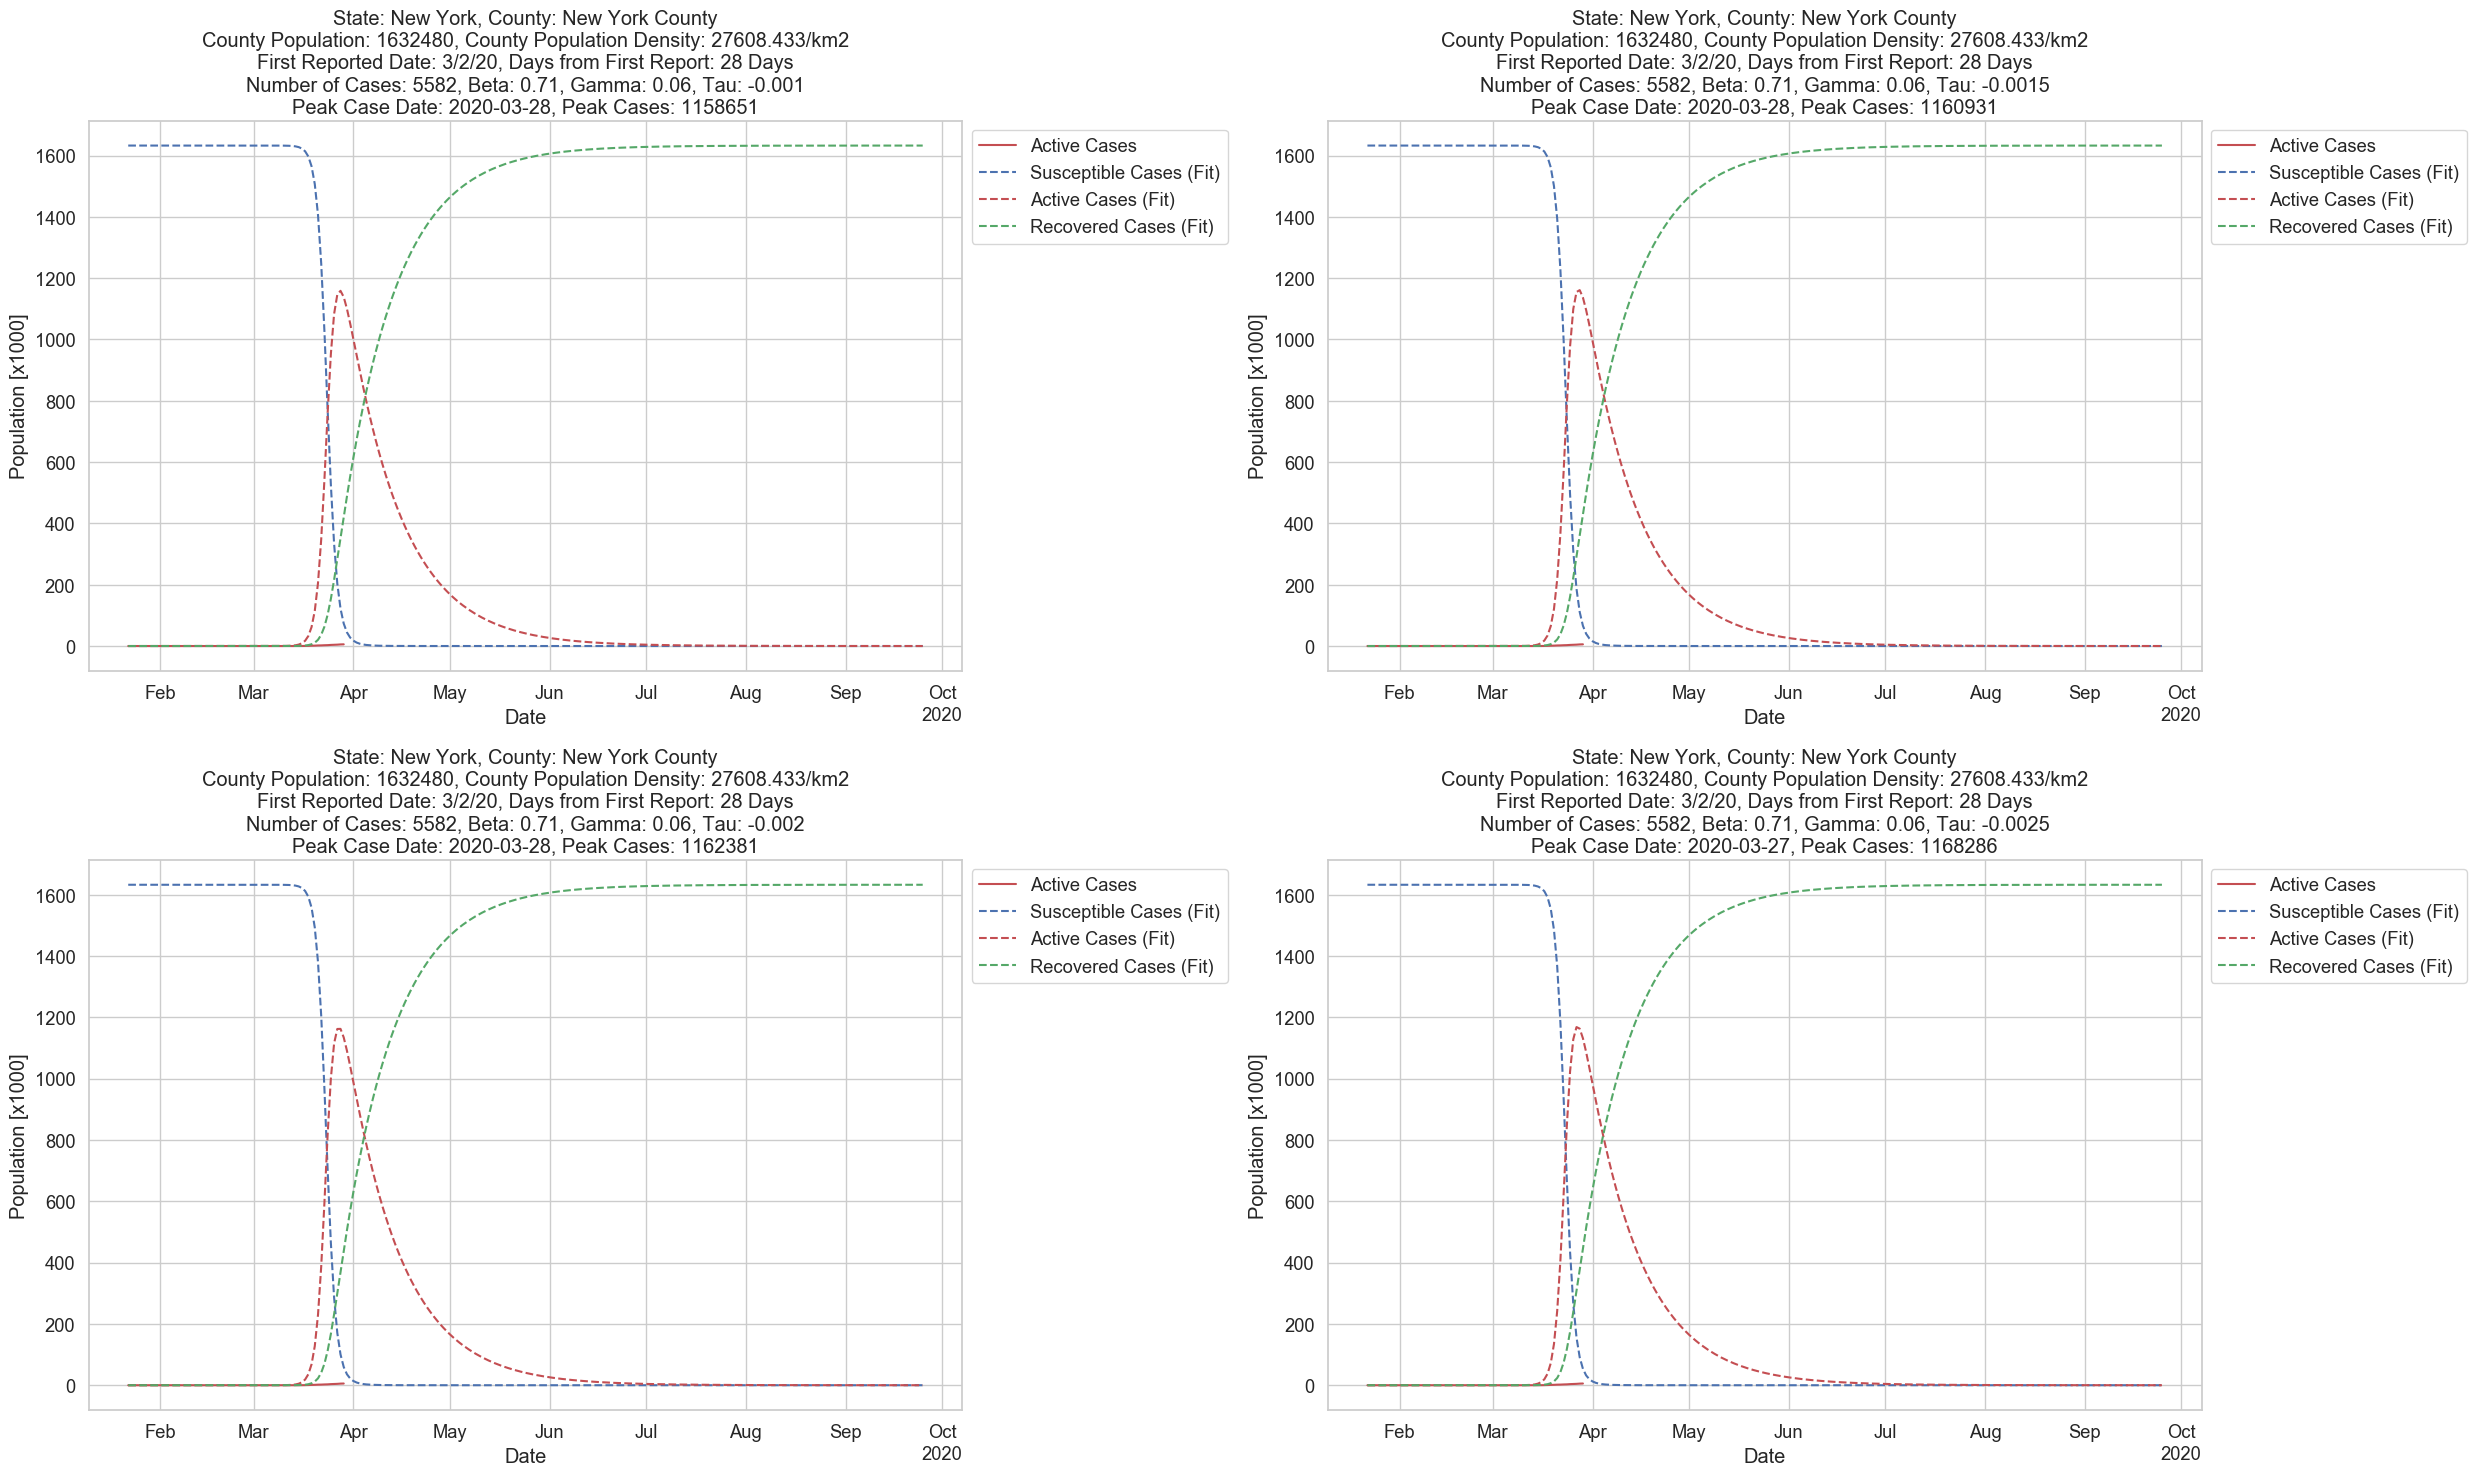

In [374]:
from pandas.plotting import register_matplotlib_converters
df_county = df_covid_county[df_covid_county['countyFIPS'] == '36061']



sns.set(font_scale=1.2)
sns.set_style('whitegrid')


taus = [-1e-3,-1.5e-3,-2e-3,-2.5e-3]
f,axes = plt.subplots(2,2,figsize=(25,15),dpi=100)


for axs,t in zip(axes.flatten(),taus):
    create_plot_county(df_county,180,gamma = 0.06,tau = t, ax=axs)
# create_plot_county(df_county,180,gamma = 0.06,tau = 0.05,ax = ax2)

    
    
plt.tight_layout();
#plt.savefig('./Images/Top10_Cars.png',bbox_inches='tight')

In [375]:
def func(x,b,c):
    return ( np.exp(b*(x**c)))

In [382]:
curve_fit(func,x,y)

(array([0.02843021, 1.36222507]), array([[ 3.96053027e-05, -3.33821180e-04],
        [-3.33821180e-04,  2.81395754e-03]]))

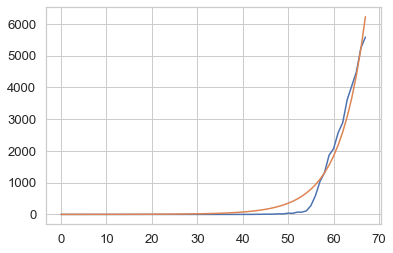

In [381]:
df_county = df_covid_county[df_covid_county['countyFIPS'] == '36061']
y = df_county[date_cols].values.flatten()
x= np.arange(0,len(y),1)
popt,pcov = curve_fit(func,x,y)
y_pred = func(x,*popt)
plt.plot(y)
plt.plot(y_pred)

In [378]:
const_b =[]
const_c = []
for county in df_covid_county['countyFIPS'].unique():
    df_county = df_covid_county[df_covid_county['countyFIPS']==county]
    if df_county[date_cols[-1]].values <= 20:
        b= 0
        c= 0
    else:
        y = df_county[date_cols].values.flatten()
        y = np.trim_zeros(y)
        x = np.arange(0,len(y),1)
        b,c = curve_fit(func, x, y, maxfev=9999999)[0]
    const_b.append(b)
    const_c.append(c)

df_covid_county['County_Exponential_Constant_b'] = const_b
df_covid_county['County_Exponential_Constant_c'] = const_c

In [336]:
bins

array([0.        , 0.05130866, 0.10261731, 0.15392597, 0.20523463,
       0.25654328, 0.30785194, 0.3591606 , 0.41046925, 0.46177791,
       0.51308657, 0.56439522, 0.61570388, 0.66701254, 0.71832119,
       0.76962985, 0.8209385 , 0.87224716, 0.92355582, 0.97486447,
       1.02617313, 1.07748179, 1.12879044, 1.1800991 , 1.23140776,
       1.28271641, 1.33402507, 1.38533373, 1.43664238, 1.48795104,
       1.5392597 , 1.59056835, 1.64187701, 1.69318567, 1.74449432,
       1.79580298, 1.84711164, 1.89842029, 1.94972895, 2.00103761,
       2.05234626, 2.10365492, 2.15496358, 2.20627223, 2.25758089,
       2.30888954, 2.3601982 , 2.41150686, 2.46281551, 2.51412417,
       2.56543283])

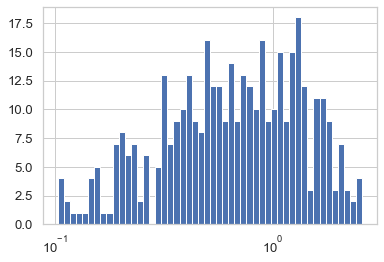

In [379]:
x = df_covid_county['County_Exponential_Constant_b']
hist, bins, _ = plt.hist(x, bins=50)
plt.close()
logbins = np.logspace(np.log10(bins[2]),np.log10(bins[-1]),len(bins))
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

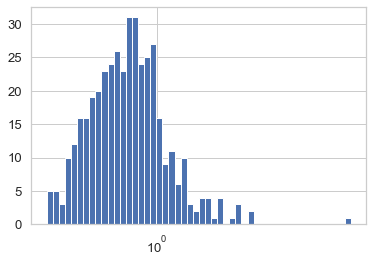

In [380]:
x = df_covid_county['County_Exponential_Constant_c']
hist, bins, _ = plt.hist(x, bins=50)
plt.close()
logbins = np.logspace(np.log10(bins[2]),np.log10(bins[-1]),len(bins))
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

In [390]:
df_covid_county[(df_covid_county['County_Exponential_Constant_c']>1)& (df_covid_county['State'] == 'MA')]

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/29/20,STATE,COUNTY,County_Population,County_Area in m2 - Total area,County_Area in m2 - Water area,County_Area in m2 - Land area,County_Population_Density_m2,County_Exponential_Constant_b,County_Exponential_Constant_c
1221,25011,Franklin County,MA,25,0,0,0,0,0,0,...,41,Massachusetts,Franklin County,70935,1.876638e+09,6.542347e+07,1.811241e+09,0.000039,0.036614,1.640351
1222,25013,Hampden County,MA,25,0,0,0,0,0,0,...,201,Massachusetts,Hampden County,469116,1.642709e+09,4.431494e+07,1.598394e+09,0.000293,0.262244,1.115677
1226,25021,Norfolk County,MA,25,0,0,0,0,0,0,...,548,Massachusetts,Norfolk County,698249,1.150868e+09,1.249417e+08,1.025926e+09,0.000681,0.222958,1.029092
1228,25025,Suffolk County,MA,25,0,0,0,0,0,0,...,940,Massachusetts,Suffolk County,791766,3.113701e+08,1.607615e+08,1.506087e+08,0.005257,0.000447,2.386316


In [393]:
df = df_covid_county[['County_Exponential_Constant_b', 'County_Population_Density_m2']]
df.corr()

,County_Exponential_Constant_b,County_Population_Density_m2
County_Exponential_Constant_b,1.000000,0.309239
County_Population_Density_m2,0.309239,1.000000


In [254]:
columns = ['County Name', 'State', date_cols[-1] , 'County_Population', 'County_Population_Density_m2']

In [255]:
columns

['County Name',
 'State',
 '3/29/20',
 'County_Population',
 'County_Population_Density_m2']

In [249]:
config_dict = {}
config_dict['input_folder'] = '/data/'
config_dict['input_file_name'] = 'US_County_Info.csv'
config_dict['Author'] = 'Swami V'
config_dict['Date'] = '03/29/2020'
config_dict['covid_data_url'] = url_covid_data
config_dict['columns'] = columns
config_dict['output_path'] = '/Output/'
config_dict["output_dataset_file_name"]= "COVID" 
# This is to create the config file for ETL job
# import json

# with open('/Users/swami/PycharmProjects/COVID-19_pip/config/config.json', 'w') as json_file:
#     json.dump(config_dict, json_file, indent=2)